# 第9章: RNNとCNN
*深層学習フレームワークを用い，再帰型ニューラルネットワーク（RNN）や畳み込みニューラルネットワーク（CNN）を実装します*

## 80 ID番号への変換

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('newsCorpora.csv', sep='\t', quoting=3, names=('id','title','url','publisher','category','story','hostname','timestamp'))
df = df.loc[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

df = df.sample(frac=1)

ratio_train, ratio_valid = 0.8, 0.1
n_train, n_valid = (np.array([ratio_train, ratio_valid]) * len(df)).astype(int)

train = df.iloc[:n_train]
valid = df.iloc[n_train:n_train+n_valid]
test = df.iloc[n_train+n_valid:]

train.to_csv('train.csv', index=False, sep='\t')
valid.to_csv('valid.csv', index=False, sep='\t')
test.to_csv('test.csv', index=False, sep='\t')

In [1]:
import numpy as np
import pandas as pd
from spacy.lang.en import English

train = pd.read_csv('train.csv', sep='\t', quoting=3)
valid = pd.read_csv('valid.csv', sep='\t', quoting=3)
test = pd.read_csv('test.csv', sep='\t', quoting=3)

In [1]:
tokenizer = English().tokenizer

counts = dict()

for title in train.title:
    for token in tokenizer(title):
        text = token.text
        counts[text] = counts.get(text, 0) + 1
        
counts = sorted(counts.items(), key=lambda item:item[1], reverse=True)
word_list = []

for word, count in counts:
    if count > 1:
        word_list.append(word)
    else:
        break
        
counts = {word:count+1 for count,word in enumerate(word_list)}

In [2]:
def title_to_ids(title):
    output = []
    for word in tokenizer(title):
        output.append(counts.get(word.text, 0))
    return np.array(output)

In [3]:
#test

title_to_ids('good - 0000')

array([1372,    1,    0])

## 81 RNNによる予測

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

n_words = len(counts)+1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Embedding(n_words, 300, dtype=torch.float64)
        self.fc1 = nn.RNN(300, 50, dtype=torch.float64, batch_first=True)
        self.fc2 = nn.Linear(50, 4, dtype=torch.float64)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x[1][0])
        return x

torch.manual_seed(42)
model = Net()

In [5]:
ids = title_to_ids(train.title.values[0])
ids = torch.from_numpy(ids)
ids

tensor([   8,  722, 2654,  723,   82,   76, 5191,  764,    8,    8,   17, 6699,
        6700,    8,    8,   35,    6,    5,    8])

In [6]:
model(ids)

tensor([ 0.6928, -0.6254,  0.6959, -0.1205], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [7]:
F.softmax(model(ids), dim=-1)

tensor([0.3684, 0.0986, 0.3696, 0.1634], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

## 82 確率的勾配降下法による学習

In [8]:
from torch.nn.utils.rnn import pad_sequence

def titles_to_x(titles):
    tensors = [torch.from_numpy(x) for x in np.vectorize(title_to_ids, otypes=[list])(titles).tolist()]
    return tensors

x_train = titles_to_x(train.title)
x_valid = titles_to_x(valid.title)
x_test = titles_to_x(test.title)

In [4]:
category_to_number = np.vectorize({'b':0, 't':1, 'e':2, 'm':3}.get)

y_train = category_to_number(train['category'])
y_valid = category_to_number(valid['category'])
y_test = category_to_number(test['category'])

y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)

In [14]:
import matplotlib.pyplot as plt

class Evaluator:
    
    def __init__(self):
        self.losses_train = []
        self.losses_valid = []
        self.accs_train = []
        self.accs_valid = []
        
    def evaluate(self, model, loss, data):       
        losses = 0
        acc = 0
        
        for x, y in data:
            y_hat = model(x)
            losses += loss(y_hat, y).item()
            if torch.argmax(y_hat, dim=-1) == y:
                acc += 1
                
        return losses, acc
    
    def append(self, model, loss):       
        loss_train, acc_train = self.evaluate(model, loss, zip(x_train, y_train))
        self.losses_train.append(loss_train / len(x_train))
        self.accs_train.append(acc_train / len(x_train))
                                               
        loss_valid, acc_valid = self.evaluate(model, loss, zip(x_valid, y_valid))
        self.losses_valid.append(loss_valid / len(x_valid))
        self.accs_valid.append(acc_valid / len(x_valid)) 
        
    def plot(self):
        ax1 = plt.subplot(211)
        plt.plot(range(len(self.losses_train)), self.losses_train, label='train')
        plt.plot(range(len(self.losses_valid)), self.losses_valid, label='valid')
        plt.legend()
        plt.ylabel('loss')
        plt.tick_params('x', labelbottom=False)

        ax2 = plt.subplot(212, sharex=ax1)
        plt.plot(range(len(self.accs_train)), self.accs_train, label='train')
        plt.plot(range(len(self.accs_valid)), self.accs_valid, label='valid')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.show()

In [11]:
from tqdm import tqdm

torch.manual_seed(42)
model = Net()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()
n_epoch = 10

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_train.to(device)
y_valid.to(device)
y_test.to(device)
model.to(device)

Net(
  (fc0): Embedding(9573, 300)
  (fc1): RNN(300, 50, batch_first=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
)

In [16]:
evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
    
    overall_loss = 0
    
    for x, y in zip(x_train, y_train):
        x.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
        overall_loss += output.item()
        
    print(overall_loss)
        
    evaluator.append(model, loss)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

12128.224611518313


 10%|████▍                                       | 1/10 [00:35<05:19, 35.54s/it]

11007.448002053734


 20%|████████▊                                   | 2/10 [01:10<04:43, 35.38s/it]

10098.618233071162


 30%|█████████████▏                              | 3/10 [01:46<04:09, 35.69s/it]

8835.449280208908


 40%|█████████████████▌                          | 4/10 [02:23<03:36, 36.13s/it]

7717.443767743471


 50%|██████████████████████                      | 5/10 [02:58<02:59, 35.84s/it]

6805.413249137066


 60%|██████████████████████████▍                 | 6/10 [03:35<02:23, 36.00s/it]

6024.338499118836


 70%|██████████████████████████████▊             | 7/10 [04:13<01:49, 36.66s/it]

5320.025307676958


 80%|███████████████████████████████████▏        | 8/10 [04:50<01:13, 36.93s/it]

4743.3237346170245


 90%|███████████████████████████████████████▌    | 9/10 [05:28<00:37, 37.11s/it]

4415.326443721497


100%|███████████████████████████████████████████| 10/10 [06:07<00:00, 36.75s/it]


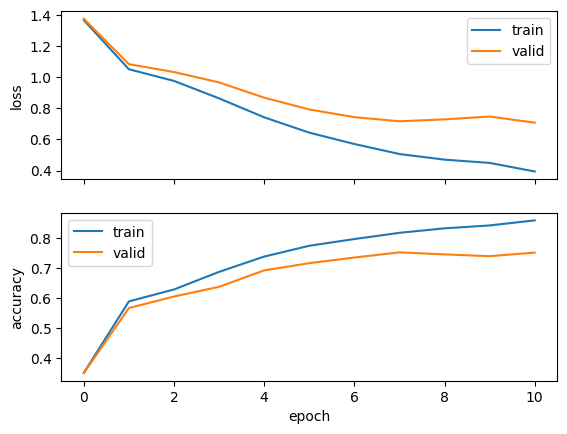

In [17]:
evaluator.plot()

## 83 ミニバッチ化・GPU上での学習

In [159]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Embedding(n_words, 300, dtype=torch.float64, padding_idx=0)
        self.fc1 = nn.RNN(300, 50, dtype=torch.float64, batch_first=True)
        self.fc2 = nn.Linear(50, 4, dtype=torch.float64)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x[1][0])
        return x

torch.manual_seed(42)
model = Net()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

In [160]:
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def custom_collate(data):    
    inputs, labels = zip(*data)
    inputs = pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels)

    return inputs, labels

loader_train = DataLoader(sorted(zip(x_train, y_train), key=lambda x:len(x[0])), batch_size=8, collate_fn=custom_collate)

In [ ]:
#左側からpaddingしてみる

# from torch.utils.data import TensorDataset, DataLoader
# from torch.nn.utils.rnn import pad_sequence

# x_train_padded = pad_sequence([i.flip(dims=[-1]) for i in x_train], batch_first=True).flip(dims=[-1])

# dataset_train = TensorDataset(x_train_padded, y_train)
# loader_train = DataLoader(dataset_train, batch_size=8)

In [161]:
from tqdm import tqdm

n_epoch = 10

evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
    
    overall_loss = 0
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
        overall_loss += output.item()
        
    print(overall_loss)
        
    evaluator.append(model, loss)

  0%|                                                      | 0/10 [00:00<?, ?it/s]

1687.413730440271


 10%|████▌                                         | 1/10 [00:06<01:01,  6.88s/it]

1571.6633236071393


 20%|█████████▏                                    | 2/10 [00:13<00:55,  6.88s/it]

1513.8664666321938


 30%|█████████████▊                                | 3/10 [00:20<00:48,  6.88s/it]

1478.9585120083473


 40%|██████████████████▍                           | 4/10 [00:27<00:41,  6.86s/it]

1455.2219632404292


 50%|███████████████████████                       | 5/10 [00:34<00:34,  6.90s/it]

1437.1948359098615


 60%|███████████████████████████▌                  | 6/10 [00:41<00:27,  6.89s/it]

1422.091406656533


 70%|████████████████████████████████▏             | 7/10 [00:48<00:20,  6.90s/it]

1408.4273819093025


 80%|████████████████████████████████████▊         | 8/10 [00:55<00:13,  6.90s/it]

1395.3707075267646


 90%|█████████████████████████████████████████▍    | 9/10 [01:02<00:06,  6.93s/it]

1382.419899981243


100%|█████████████████████████████████████████████| 10/10 [01:09<00:00,  6.93s/it]


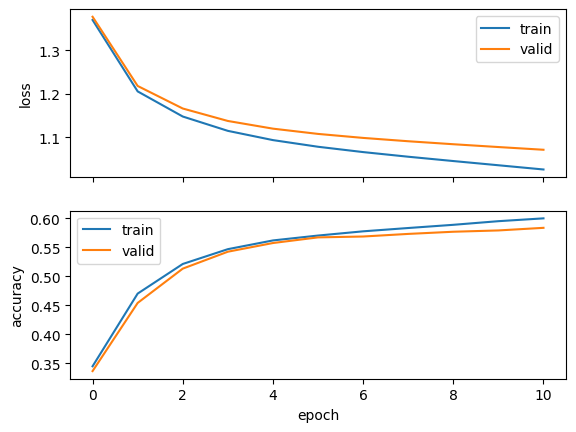

In [162]:
evaluator.plot()

## 84 単語ベクトルの導入

In [165]:
from pymagnitude import Magnitude

vecs = Magnitude('GoogleNews-vectors-negative300.magnitude')

weights = [np.zeros(300)]

for word in word_list:
    weights.append(vecs.query(word))

embedding = nn.Embedding.from_pretrained(torch.DoubleTensor(np.array(weights)), padding_idx=0)

In [258]:
torch.manual_seed(42)
model = Net()
model.fc0 = embedding

In [259]:
#今度こそ左側からpaddingしてみるぞ！

x_train_padded = pad_sequence([i.flip(dims=[-1]) for i in x_train], batch_first=True).flip(dims=[-1])

dataset_train = TensorDataset(x_train_padded, y_train)
loader_train = DataLoader(dataset_train, batch_size=8)

In [260]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

In [261]:
from tqdm import tqdm

n_epoch = 100

evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
    
    overall_loss = 0
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
        overall_loss += output.item()
        
    #print(overall_loss)
        
    evaluator.append(model, loss)

100%|█████████████████████████████████████████████| 100/100 [06:30<00:00,  3.91s/it]


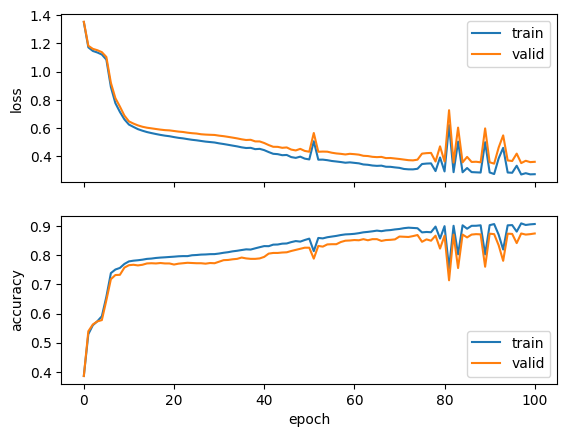

In [262]:
evaluator.plot()

## 85 双方向RNN・多層化

In [253]:
class SuperNet(nn.Module):
    def __init__(self):
        super(SuperNet, self).__init__()
        self.fc0 = nn.Embedding(n_words, 300, dtype=torch.float64, padding_idx=0)
        self.fc1 = nn.RNN(300, 50, dtype=torch.float64, batch_first=True, num_layers=2, bidirectional=True)
        self.fc2 = nn.Linear(100, 4, dtype=torch.float64)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x[0].select(-2, -1))
        return x

In [254]:
torch.manual_seed(42)
model = SuperNet()
model.fc0 = embedding

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

In [255]:
from tqdm import tqdm

n_epoch = 10

evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
    
    overall_loss = 0
    
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
        overall_loss += output.item()
        
    print(overall_loss)
        
    evaluator.append(model, loss)

  0%|                                                      | 0/10 [00:00<?, ?it/s]

1605.2871487047612


 10%|████▌                                         | 1/10 [00:12<01:54, 12.71s/it]

1528.455752837405


 20%|█████████▏                                    | 2/10 [00:25<01:41, 12.72s/it]

1510.6128863747458


 30%|█████████████▊                                | 3/10 [00:38<01:29, 12.73s/it]

1491.1384422077847


 40%|██████████████████▍                           | 4/10 [00:50<01:16, 12.71s/it]

1467.9074980143694


 50%|███████████████████████                       | 5/10 [01:03<01:03, 12.68s/it]

1437.8321684453801


 60%|███████████████████████████▌                  | 6/10 [01:16<00:50, 12.68s/it]

1380.8902712847205


 70%|████████████████████████████████▏             | 7/10 [01:28<00:38, 12.68s/it]

1110.8659038638646


 80%|████████████████████████████████████▊         | 8/10 [01:41<00:25, 12.70s/it]

940.7734698827612


 90%|█████████████████████████████████████████▍    | 9/10 [01:54<00:12, 12.74s/it]

875.3549937260128


100%|█████████████████████████████████████████████| 10/10 [02:07<00:00, 12.75s/it]


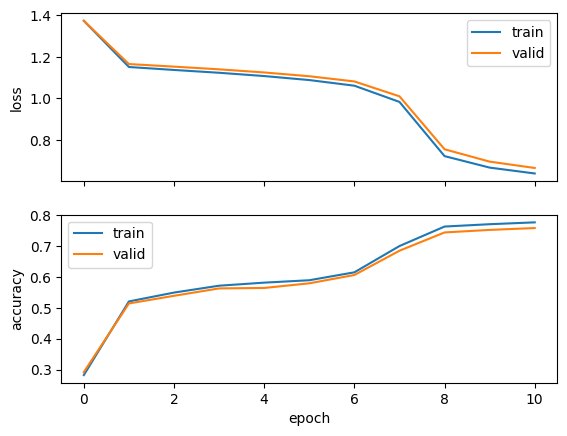

In [256]:
evaluator.plot()

## 86 畳み込みニューラルネットワーク (CNN)

In [342]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.emb = nn.Embedding(n_words, 300, dtype=torch.float64, padding_idx=0)
        self.conv = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=(3, 300), stride=1, padding=(1, 0), dtype=torch.float64)
        self.linear = nn.Linear(50, 4, dtype=torch.float64)
        
    def forward(self, x):
        x = self.emb(x)
        x = self.conv(x.unsqueeze(0))
        x = F.relu(x.squeeze(2))
        x = F.max_pool1d(x, x.shape[-1]).squeeze(1)
        x = self.linear(x)
        return x

torch.manual_seed(42)
model = CNN()

F.softmax(model(x_train[0]), dim=-1)

tensor([0.2525, 0.4512, 0.1592, 0.1370], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)

## 87 確率的勾配降下法によるCNNの学習

In [347]:
from tqdm import tqdm

torch.manual_seed(42)
model = CNN()
model.emb = embedding

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()
n_epoch = 10

In [348]:
evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
    
    overall_loss = 0
    
    for x, y in zip(x_train, y_train):
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
        overall_loss += output.item()
        
    print(overall_loss)
        
    evaluator.append(model, loss)

  0%|                                                   | 0/10 [00:00<?, ?it/s]

12507.5998390075


 10%|████▎                                      | 1/10 [00:05<00:50,  5.56s/it]

10553.88887276625


 20%|████████▌                                  | 2/10 [00:11<00:44,  5.57s/it]

8182.757735211457


 30%|████████████▉                              | 3/10 [00:16<00:39,  5.62s/it]

7039.440568744437


 40%|█████████████████▏                         | 4/10 [00:22<00:33,  5.60s/it]

6428.144133211857


 50%|█████████████████████▌                     | 5/10 [00:27<00:27,  5.58s/it]

5990.005475490396


 60%|█████████████████████████▊                 | 6/10 [00:33<00:22,  5.56s/it]

5632.0113353172765


 70%|██████████████████████████████             | 7/10 [00:38<00:16,  5.55s/it]

5316.884551289083


 80%|██████████████████████████████████▍        | 8/10 [00:44<00:11,  5.55s/it]

5025.8484252253065


 90%|██████████████████████████████████████▋    | 9/10 [00:50<00:05,  5.58s/it]

4749.587799262155


100%|██████████████████████████████████████████| 10/10 [00:55<00:00,  5.58s/it]


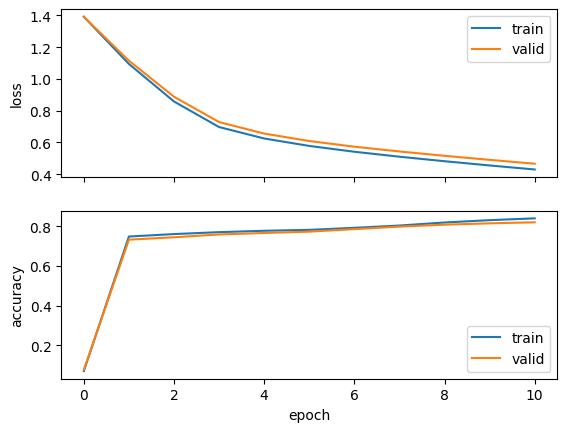

In [349]:
evaluator.plot()

## 88 パラメータチューニング

In [352]:
#based on 84

from torch.optim.lr_scheduler import MultiStepLR

torch.manual_seed(42)
model = Net()
model.fc0 = embedding

x_train_padded = pad_sequence([i.flip(dims=[-1]) for i in x_train], batch_first=True).flip(dims=[-1])
dataset_train = TensorDataset(x_train_padded, y_train)
loader_train = DataLoader(dataset_train, batch_size=8)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, milestones=[50], gamma=0.3) #scheduler added

loss = nn.CrossEntropyLoss(reduction='mean')
evaluator = Evaluator()

n_epoch = 100 #n_epoch increased to 100

evaluator.append(model, loss)

for i in tqdm(range(n_epoch)):
        
    for x, y in loader_train:
        optimizer.zero_grad()
        y_hat = model(x)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    evaluator.append(model, loss)    
    scheduler.step()

100%|████████████████████████████████████████| 100/100 [06:25<00:00,  3.86s/it]


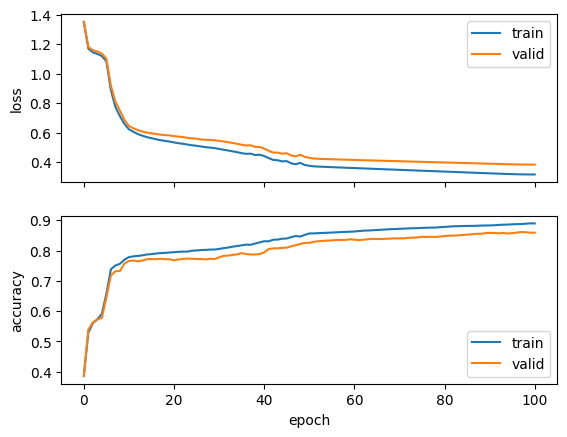

In [353]:
evaluator.plot()

## 89 事前学習済み言語モデルからの転移学習

In [6]:
from transformers import BertModel, BertTokenizer
import torch
from torch import nn

In [10]:
#prepare data

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

padded_sequences_train = tokenizer(train['title'].tolist(), padding=True)
padded_sequences_valid = tokenizer(valid['title'].tolist(), padding=True)

ids_train = torch.LongTensor(padded_sequences_train['input_ids'])
masks_train = torch.LongTensor(padded_sequences_train['attention_mask'])

ids_valid = torch.LongTensor(padded_sequences_valid['input_ids'])
masks_valid = torch.LongTensor(padded_sequences_valid['attention_mask'])

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(ids_train, masks_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=32)

dataset_valid = TensorDataset(ids_valid, masks_valid, y_valid)
loader_valid = DataLoader(dataset_valid, batch_size=32)

In [93]:
#define model

class BertNet(nn.Module):
    def __init__(self):
        super(BertNet, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 4)
        
    def forward(self, ids, masks):
        _, out = self.bert(ids, attention_mask=masks, return_dict=False)
        out = self.linear(out)
        return out

torch.manual_seed(42)
model = BertNet()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
#define evaluator for evaluation & graphing

from tqdm import tqdm

class BertEvaluator(Evaluator):
            
    def evaluate(self, model, loss, loader):       
        losses = 0
        acc = 0
        
        for ids, masks, y in tqdm(loader):           
            y_hat = model(ids, masks)           
            losses += loss(y_hat, y).item()           
            acc += (torch.argmax(y_hat, dim=-1) == y).numpy().sum()
                
        return losses, acc
    
    def append(self, model, loss):       
        loss_train, acc_train = self.evaluate(model, loss, loader_train)
        self.losses_train.append(loss_train / len(y_train))
        self.accs_train.append(acc_train / len(y_train))
                                               
        loss_valid, acc_valid = self.evaluate(model, loss, loader_valid)
        self.losses_valid.append(loss_valid / len(y_valid))
        self.accs_valid.append(acc_valid / len(y_valid)) 

In [95]:
#train & evaluate

from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#scheduler = ExponentialLR(optimizer, gamma=0.5)

loss = nn.CrossEntropyLoss(reduction='mean')
loss_eval = nn.CrossEntropyLoss(reduction='sum')
evaluator = BertEvaluator()

n_epoch = 5

evaluator.append(model, loss_eval)

for i in range(n_epoch):
        
    for ids, masks, y in tqdm(loader_train):
        optimizer.zero_grad()
        y_hat = model(ids, masks)
        output = loss(y_hat, y)
        output.backward()
        optimizer.step()
        
    evaluator.append(model, loss_eval)    
    #scheduler.step()

100%|██████████████████████████████████████████| 42/42 [00:18<00:00,  2.32it/s]


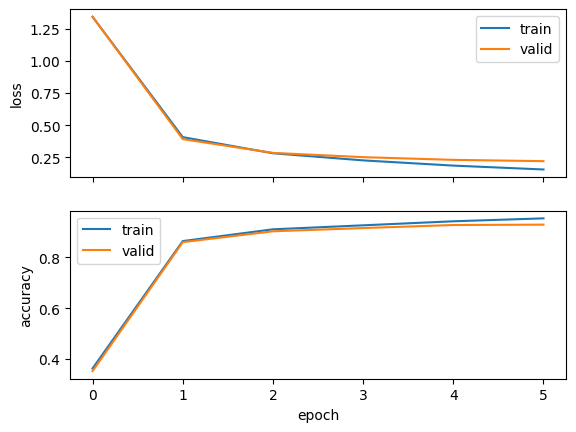

In [96]:
evaluator.plot()

In [97]:
evaluator.accs_train

[0.3625982777985773,
 0.8640958442530887,
 0.9104268064395358,
 0.9261512542119057,
 0.9420628977910894,
 0.953575439910146]

In [98]:
evaluator.accs_valid

[0.352059925093633,
 0.8599250936329588,
 0.9026217228464419,
 0.9153558052434457,
 0.9273408239700375,
 0.9288389513108615]